In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import sys

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

sys.path.insert(0,'../charles/helpers')
import helper
import joblib
import itertools
from statistics import mean

In [160]:
data = pd.read_csv('../communal/Ames_Housing_Price_Data_cleaned_2.csv', header = [0])
data.head()

pd.set_option("display.max_columns", None)

data.drop(['PID', 'lot_bucket', 'mean_LotFrontage', 'Prop_Addr', 'GarageYrBlt', 'lat', 'long'], axis = 1, inplace = True)

data.drop(['YearRemodAdd', 'Exterior2nd', 'BsmtFinSF1', 'BsmtFinSF2',
           'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
           'TotRmsAbvGrd', 'GarageCars'], axis = 1, inplace = True)
data['Total_Porch'] = data['OpenPorchSF'] + data['EnclosedPorch'] + \
                      data['3SsnPorch'] + data['ScreenPorch']
data.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'],
           axis = 1, inplace = True)

In [161]:
top_20_list = ['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'OverallCond', 'YearBuilt',
              'GarageArea', 'BsmtFullBath', 'Neighborhood_Crawfor', 'CentralAir_Y',
              'Neighborhood_Somerst', 'BldgType_Twnhs', 'BsmtExposure_Gd', 
              'Neighborhood_Edwards', 'KitchenQual_TA', 'Neighborhood_MeadowV',
              'Condition1_Norm', 'Neighborhood_NridgHt', 'Fireplaces', 'MSZoning_RL',
              'HeatingQC_TA']

In [162]:
top_10_list = ['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'OverallCond', 'YearBuilt',
              'GarageArea', 'BsmtFullBath', 'Neighborhood_Crawfor', 'CentralAir_Y',
              'Neighborhood_Somerst']

In [163]:
top_20_subset_list = []
for i in range(len(top_20_list)):
    top_20_subset_list.append(top_20_list[:i+1])

In [164]:
y = data['SalePrice'].apply(lambda x: np.log(x))
x = data.drop(['SalePrice'], axis = 1)
x = pd.get_dummies(x, drop_first = True)
x = x[top_20_list]

In [5]:
train_scores = []
test_scores = []
alphas = []
feature_positions = {}
beta_list = []

In [6]:
for i in range(5):
    np.random.seed(i)
    x_train, x_test, y_train, y_test = train_test_split(x,y)
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    params = {'alpha': np.linspace(1e-6,1e-3,5000)}
    model = GridSearchCV(Lasso(max_iter = 500000), params, cv = 5)
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    train_scores.append(train_score)
    model.fit(x_test, y_test)
    test_score = model.score(x_test, y_test)
    test_scores.append(test_score)
    alphas.append(model.best_estimator_.alpha)
    coefs = model.best_estimator_.coef_
    coef_list = list(zip(coefs, x.columns))
    sorted_coef_list = sorted(coef_list, key = lambda x: abs(x[0]), reverse = True)
    beta_list.append(sorted_coef_list)
    for i in range(len(sorted_coef_list)):
        feature = sorted_coef_list[i][1]
        if feature in feature_positions.keys():
            feature_positions[feature] += i
        else:
            feature_positions[feature] = i

In [7]:
feature_positions_sorted = sorted(feature_positions.items(), key=lambda item: item[1])
feature_positions_sorted

[('GrLivArea', 0),
 ('OverallQual', 5),
 ('OverallCond', 11),
 ('YearBuilt', 16),
 ('TotalBsmtSF', 19),
 ('GarageArea', 26),
 ('Fireplaces', 30),
 ('BsmtFullBath', 35),
 ('Neighborhood_Somerst', 46),
 ('BldgType_Twnhs', 50),
 ('Neighborhood_Crawfor', 54),
 ('Neighborhood_MeadowV', 55),
 ('CentralAir_Y', 59),
 ('MSZoning_RL', 66),
 ('BsmtExposure_Gd', 67),
 ('Neighborhood_NridgHt', 68),
 ('Condition1_Norm', 80),
 ('Neighborhood_Edwards', 80),
 ('HeatingQC_TA', 91),
 ('KitchenQual_TA', 92)]

In [8]:
train_scores

[0.9029072028176085,
 0.9058287735454705,
 0.9155321085295547,
 0.9036580632960027,
 0.9183098729250155]

In [9]:
test_scores

[0.9291293899985396,
 0.9196709802363965,
 0.8906903694981577,
 0.9226281237163333,
 0.8851619846477974]

In [10]:
alphas

[2.997679535907182e-05,
 1e-06,
 0.00016406941388277658,
 9.372574514902982e-05,
 0.00039568393678735756]

In [11]:
beta_list

[[(1.236195183009068, 'GrLivArea'),
  (0.5861016352524929, 'OverallQual'),
  (0.4181182378683732, 'TotalBsmtSF'),
  (0.35937270457668163, 'OverallCond'),
  (0.35403562161446395, 'YearBuilt'),
  (0.24355167667625766, 'GarageArea'),
  (0.18867235780195407, 'BsmtFullBath'),
  (0.17215824553653616, 'Fireplaces'),
  (-0.10992133733959639, 'Neighborhood_MeadowV'),
  (0.10894241068759243, 'Neighborhood_Somerst'),
  (0.1074358319224322, 'CentralAir_Y'),
  (0.10622766386706751, 'Neighborhood_NridgHt'),
  (-0.10028974805141107, 'BldgType_Twnhs'),
  (0.08930242457072274, 'Neighborhood_Crawfor'),
  (0.06529282757785988, 'BsmtExposure_Gd'),
  (0.05270134167222092, 'MSZoning_RL'),
  (0.03430842741127964, 'Condition1_Norm'),
  (-0.03378740869003471, 'Neighborhood_Edwards'),
  (-0.026884635765353534, 'KitchenQual_TA'),
  (-0.017867314944065196, 'HeatingQC_TA')],
 [(1.234486430549909, 'GrLivArea'),
  (0.5372989144043461, 'OverallQual'),
  (0.43490393551036827, 'OverallCond'),
  (0.40422580363774596, 'Y

In [13]:
train_scores = []
test_scores = []
alphas = []
feature_positions = {}
beta_list = []

In [15]:
for i in range(len(top_20_subset_list)):
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(x[top_20_subset_list[i]],y)
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    params = {'alpha': np.linspace(1e-6,1e-3,5000)}
    model = GridSearchCV(Lasso(max_iter = 500000), params, cv = 5)
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    train_scores.append(train_score)
    model.fit(x_test, y_test)
    test_score = model.score(x_test, y_test)
    test_scores.append(test_score)
    alphas.append(model.best_estimator_.alpha)
    coefs = model.best_estimator_.coef_
    coef_list = list(zip(coefs, x.columns))
    sorted_coef_list = sorted(coef_list, key = lambda x: abs(x[0]), reverse = True)
    beta_list.append(sorted_coef_list)
    for i in range(len(sorted_coef_list)):
        feature = sorted_coef_list[i][1]
        if feature in feature_positions.keys():
            feature_positions[feature] += i
        else:
            feature_positions[feature] = i

In [16]:
feature_positions_sorted = sorted(feature_positions.items(), key=lambda item: item[1])
feature_positions_sorted

[('GrLivArea', 3),
 ('OverallQual', 16),
 ('HeatingQC_TA', 19),
 ('Fireplaces', 21),
 ('MSZoning_RL', 30),
 ('TotalBsmtSF', 36),
 ('Neighborhood_NridgHt', 42),
 ('Neighborhood_MeadowV', 46),
 ('YearBuilt', 50),
 ('OverallCond', 65),
 ('Condition1_Norm', 73),
 ('GarageArea', 75),
 ('BsmtFullBath', 84),
 ('BldgType_Twnhs', 95),
 ('CentralAir_Y', 104),
 ('BsmtExposure_Gd', 106),
 ('KitchenQual_TA', 107),
 ('Neighborhood_Crawfor', 116),
 ('Neighborhood_Edwards', 120),
 ('Neighborhood_Somerst', 122)]

In [17]:
train_scores

[0.5193702197328203,
 0.7580701454362125,
 0.7972913141925813,
 0.8043421971569074,
 0.8576060177866031,
 0.8651676558541922,
 0.8707853539051456,
 0.8770225071257487,
 0.8782497226717894,
 0.878360715682515,
 0.884688375769208,
 0.8877491136839522,
 0.8879847710360146,
 0.8888485675961358,
 0.8902275185964874,
 0.8924947442695302,
 0.8933793583232266,
 0.8973750560247125,
 0.901297696453531,
 0.9029072028176085]

In [18]:
test_scores

[0.521056235424243,
 0.8009629269849012,
 0.8438651892003075,
 0.8458677004671207,
 0.8833236399449876,
 0.8938044424088071,
 0.9024624147188778,
 0.9064457189172435,
 0.9104953165122196,
 0.9106368187964564,
 0.914203253074235,
 0.9163274367485296,
 0.9163734940942885,
 0.9172738777998651,
 0.9193976450373007,
 0.9201023302746671,
 0.9229773100580597,
 0.9272601952923174,
 0.9287503363104926,
 0.9291293899985396]

In [19]:
alphas

[0.00028717083416683343,
 0.00013329405881176237,
 8.07361472294459e-05,
 4.8961592318463694e-05,
 5.495679135827166e-05,
 4.87617523504701e-05,
 4.3972794558911785e-06,
 1.1998399679935986e-06,
 1e-06,
 1e-06,
 1e-06,
 1e-06,
 1e-06,
 1e-06,
 1e-06,
 1e-06,
 1e-06,
 7.39487897579516e-06,
 2.8777755551110225e-05,
 2.997679535907182e-05]

In [20]:
beta_list

[[(2.4038949433044894, 'GrLivArea')],
 [(1.5572376307143196, 'OverallQual'), (1.1942778231118267, 'GrLivArea')],
 [(1.297759883315263, 'OverallQual'),
  (1.0988065846339514, 'GrLivArea'),
  (0.7159145338660822, 'TotalBsmtSF')],
 [(1.2844182067693584, 'OverallQual'),
  (1.118445716255439, 'GrLivArea'),
  (0.7499128359512695, 'TotalBsmtSF'),
  (0.12317903442902242, 'OverallCond')],
 [(1.3412288232287901, 'GrLivArea'),
  (0.8680012354033471, 'OverallQual'),
  (0.65399552022175, 'TotalBsmtSF'),
  (0.48466895781163283, 'YearBuilt'),
  (0.3913135028637336, 'OverallCond')],
 [(1.223701101659399, 'GrLivArea'),
  (0.7932039210147362, 'OverallQual'),
  (0.6066445714784028, 'TotalBsmtSF'),
  (0.43798614140197356, 'YearBuilt'),
  (0.3985673632925124, 'OverallCond'),
  (0.35886504807022734, 'GarageArea')],
 [(1.274755022830199, 'GrLivArea'),
  (0.790337335565123, 'OverallQual'),
  (0.5152081905220111, 'TotalBsmtSF'),
  (0.41837147141092446, 'YearBuilt'),
  (0.4049688437420583, 'OverallCond'),
  (0.

In [23]:
def sub_lists(lst):
    lists = [[]]
    for i in range(len(lst) + 1):
        for j in range(i):
            lists.append(lst[j:i])
    return lists

In [45]:
top_10_all_subsets = sub_lists(top_10_list)[1:]

In [46]:
train_scores = []
test_scores = []
alphas = []
beta_list = []

In [47]:
for i in range(len(top_10_all_subsets)):
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(x[top_10_all_subsets[i]],y)
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    params = {'alpha': np.linspace(1e-7,1e-3,5000)}
    model = GridSearchCV(Lasso(max_iter = 500000), params, cv = 5)
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    train_scores.append(train_score)
    model.fit(x_test, y_test)
    test_score = model.score(x_test, y_test)
    test_scores.append(test_score)
    alphas.append(model.best_estimator_.alpha)
    coefs = model.best_estimator_.coef_
    coef_list = list(zip(coefs, x[top_10_all_subsets[i]].columns))
    sorted_coef_list = sorted(coef_list, key = lambda x: abs(x[0]), reverse = True)
    beta_list.append(sorted_coef_list)

In [49]:
all_values = list(zip(train_scores, test_scores, alphas, beta_list))
all_values

[(0.5193702197328203,
  0.521056235424243,
  0.00028717083416683343,
  [(2.4038949433044894, 'GrLivArea')]),
 (0.7607137563281812,
  0.791603247811749,
  9.852190438087618e-05,
  [(1.4386798650163983, 'OverallQual'), (1.3818669995220434, 'GrLivArea')]),
 (0.667686769762418,
  0.6708110356656123,
  0.00016287037407481498,
  [(2.0961267414805183, 'OverallQual')]),
 (0.8158835328551695,
  0.7859920991439497,
  1.7993598719743948e-06,
  [(1.3527647649826045, 'OverallQual'),
   (0.9669873539178052, 'GrLivArea'),
   (0.6373801873875569, 'TotalBsmtSF')]),
 (0.728278631119879,
  0.7398933462913694,
  0.00020283836767353474,
  [(1.727396464461811, 'OverallQual'), (0.8628927552020964, 'TotalBsmtSF')]),
 (0.40980115569873354,
  0.44626160992124864,
  0.0003331340268053611,
  [(1.952262184758888, 'TotalBsmtSF')]),
 (0.8202932372824678,
  0.7953829459214035,
  0.00013049629925985197,
  [(1.2852562769952731, 'OverallQual'),
   (1.2134815444083207, 'GrLivArea'),
   (0.7035931927522036, 'TotalBsmtSF')

In [50]:
sorted_all_values = sorted(all_values, key = lambda x: len(x[3]))
sorted_all_values

[(0.5193702197328203,
  0.521056235424243,
  0.00028717083416683343,
  [(2.4038949433044894, 'GrLivArea')]),
 (0.667686769762418,
  0.6708110356656123,
  0.00016287037407481498,
  [(2.0961267414805183, 'OverallQual')]),
 (0.40980115569873354,
  0.44626160992124864,
  0.0003331340268053611,
  [(1.952262184758888, 'TotalBsmtSF')]),
 (0.00028227826354532137,
  0.019938393303322255,
  1e-06,
  [(-0.41005104009927235, 'OverallCond')]),
 (0.3756969516122417,
  0.29465025825576263,
  0.0007693846769353872,
  [(0.9751740390330399, 'YearBuilt')]),
 (0.4124363464149833,
  0.427283535811243,
  0.0007587931586317265,
  [(1.66733308045504, 'GarageArea')]),
 (0.06821095755007944,
  0.1178797077751429,
  0.0004182658531706342,
  [(0.7399244022183785, 'BsmtFullBath')]),
 (0.006878246250754616,
  0.004594890164408394,
  1e-06,
  [(0.12466476822248408, 'Neighborhood_Crawfor')]),
 (0.13498572850456103,
  0.10744007654231169,
  0.00042785817163432696,
  [(0.5669384712943206, 'CentralAir_Y')]),
 (0.0327177

In [103]:
from collections import defaultdict
import pprint
d = defaultdict(list)

for val in all_values:
#     print(val[3])
    d[len(val[3])].append(val)
# pprint.pprint(d)

# for k in d.keys():
#     print(max([d[k][1]]))
for k in d.keys():
    print([d[k][i][1] for i in range(3)])

IndexError: list index out of range

In [104]:
print([d[k][1][1] for i in range(3)])

[0.6708110356656123, 0.6708110356656123, 0.6708110356656123]


In [65]:
feature_lengths_dict = {}
for i in range(1,11):
    feature_lengths_dict[i] = []

In [67]:
feature_lengths_dict

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}

In [86]:
for val in all_values:
    for feature_length in range(1,11):
        if len(val[3]) == feature_length:
            feature_lengths_dict[feature_length].append(val)

In [87]:
feature_lengths_dict[1]

[0.5193702197328203,
 0.521056235424243,
 0.00028717083416683343,
 [(2.4038949433044894, 'GrLivArea')],
 0.667686769762418,
 0.6708110356656123,
 0.00016287037407481498,
 [(2.0961267414805183, 'OverallQual')],
 0.40980115569873354,
 0.44626160992124864,
 0.0003331340268053611,
 [(1.952262184758888, 'TotalBsmtSF')],
 0.00028227826354532137,
 0.019938393303322255,
 1e-06,
 [(-0.41005104009927235, 'OverallCond')],
 0.3756969516122417,
 0.29465025825576263,
 0.0007693846769353872,
 [(0.9751740390330399, 'YearBuilt')],
 0.4124363464149833,
 0.427283535811243,
 0.0007587931586317265,
 [(1.66733308045504, 'GarageArea')],
 0.06821095755007944,
 0.1178797077751429,
 0.0004182658531706342,
 [(0.7399244022183785, 'BsmtFullBath')],
 0.006878246250754616,
 0.004594890164408394,
 1e-06,
 [(0.12466476822248408, 'Neighborhood_Crawfor')],
 0.13498572850456103,
 0.10744007654231169,
 0.00042785817163432696,
 [(0.5669384712943206, 'CentralAir_Y')],
 0.03271778225053512,
 0.03948308216743057,
 1e-06,
 [(0

In [83]:
feature_lengths_dict[1][1]

[0.5193702197328203,
 0.521056235424243,
 0.00028717083416683343,
 [(2.4038949433044894, 'GrLivArea')],
 0.667686769762418,
 0.6708110356656123,
 0.00016287037407481498,
 [(2.0961267414805183, 'OverallQual')],
 0.40980115569873354,
 0.44626160992124864,
 0.0003331340268053611,
 [(1.952262184758888, 'TotalBsmtSF')],
 0.00028227826354532137,
 0.019938393303322255,
 1e-06,
 [(-0.41005104009927235, 'OverallCond')],
 0.3756969516122417,
 0.29465025825576263,
 0.0007693846769353872,
 [(0.9751740390330399, 'YearBuilt')],
 0.4124363464149833,
 0.427283535811243,
 0.0007587931586317265,
 [(1.66733308045504, 'GarageArea')],
 0.06821095755007944,
 0.1178797077751429,
 0.0004182658531706342,
 [(0.7399244022183785, 'BsmtFullBath')],
 0.006878246250754616,
 0.004594890164408394,
 1e-06,
 [(0.12466476822248408, 'Neighborhood_Crawfor')],
 0.13498572850456103,
 0.10744007654231169,
 0.00042785817163432696,
 [(0.5669384712943206, 'CentralAir_Y')],
 0.03271778225053512,
 0.03948308216743057,
 1e-06,
 [(0

In [79]:
for key in feature_lengths_dict:
    print(max(feature_lengths_dict[key][1])

TypeError: 'numpy.float64' object is not iterable

In [64]:
best_test_feature_length

[(0.8946765609387464,
  0.8553237616845037,
  0.00042705881176235256,
  [(1.0839002269631965, 'GrLivArea'),
   (0.7421100764229828, 'OverallQual'),
   (0.45012063172049316, 'YearBuilt'),
   (0.41335349508296315, 'OverallCond'),
   (0.4110614745599814, 'TotalBsmtSF'),
   (0.35161987894434565, 'GarageArea'),
   (0.20312701194612967, 'BsmtFullBath'),
   (0.13924779567979653, 'Neighborhood_Crawfor'),
   (0.1047454484008123, 'CentralAir_Y')]),
 (0.8946765609387464,
  0.8553237616845037,
  0.00042705881176235256,
  [(1.0839002269631965, 'GrLivArea'),
   (0.7421100764229828, 'OverallQual'),
   (0.45012063172049316, 'YearBuilt'),
   (0.41335349508296315, 'OverallCond'),
   (0.4110614745599814, 'TotalBsmtSF'),
   (0.35161987894434565, 'GarageArea'),
   (0.20312701194612967, 'BsmtFullBath'),
   (0.13924779567979653, 'Neighborhood_Crawfor'),
   (0.1047454484008123, 'CentralAir_Y')]),
 (0.8946765609387464,
  0.8553237616845037,
  0.00042705881176235256,
  [(1.0839002269631965, 'GrLivArea'),
   (0.

In [174]:
train_scores = []
test_scores = []
alphas = []
betas = []

In [175]:
for i in range(len(top_20_subset_list)):
    train_list = []
    test_list = []
    alpha_list = []
    beta_list = []
    for j in range(50):
        np.random.seed(j)
        x_train, x_test, y_train, y_test = train_test_split(x[top_20_subset_list[i]],y)
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        params = {'alpha': np.linspace(1e-7,1e-3,5000)}
        model = GridSearchCV(Lasso(max_iter = 500000), params, cv = 5)
        model.fit(x_train, y_train)
        train_score = model.score(x_train, y_train)
        train_list.append(train_score)
        model.fit(x_test, y_test)
        test_score = model.score(x_test, y_test)
        test_list.append(test_score)
        alpha_list.append(model.best_estimator_.alpha)
        coefs = model.best_estimator_.coef_
        coef_list = list(zip(coefs, x[top_20_subset_list[i]].columns))
        sorted_coef_list = sorted(coef_list, key = lambda x: abs(x[0]), reverse = True)
        beta_list.append(sorted_coef_list)
    train_scores.append(train_list)
    test_scores.append(test_list)
    alphas.append(alpha_list)
    betas.append(beta_list)

In [179]:
train_scores

[[0.519370244235783,
  0.5215624537882536,
  0.5271879858154813,
  0.5171618361490588,
  0.5407847618106022,
  0.5107431129422997,
  0.5221598679309815,
  0.5191179241747631,
  0.5315034467747359,
  0.5117577653085222,
  0.5100754006020096,
  0.5066871968275947,
  0.5114539213184338,
  0.5272352769267705,
  0.5278302911053891,
  0.5227860866050185,
  0.52623722402856,
  0.5238468369446949,
  0.5114558558847488,
  0.5270860887736932,
  0.514437098906039,
  0.5398752346045812,
  0.5232698399899716,
  0.5342481309930032,
  0.5209634220412009,
  0.5236083209040661,
  0.5132623290304064,
  0.5129088754674112,
  0.50826687040191,
  0.5236814244860002,
  0.5387742359121972,
  0.5155431094408378,
  0.5269296620663831,
  0.5088005469020945,
  0.5194368718929532,
  0.5245753116997958,
  0.5374712086079869,
  0.5214149136358287,
  0.5187220446542202,
  0.5046999128360309,
  0.5286998672306646,
  0.5206783328548602,
  0.5216185368950029,
  0.5279349499038118,
  0.5267166919207091,
  0.527127653907

In [180]:
test_scores

[[0.5210561846196862,
  0.513195283761489,
  0.4974184569790294,
  0.5281682886144783,
  0.4629721521609732,
  0.5478528375936154,
  0.5124903509143507,
  0.5217831896079753,
  0.48787293688293776,
  0.5454595886243638,
  0.5519040470853722,
  0.556962082615726,
  0.5454707584849761,
  0.497812233385451,
  0.5015842589405612,
  0.5088218955824992,
  0.5043171824604186,
  0.5107920313717695,
  0.5453986260521324,
  0.49805377714955956,
  0.5382688227544777,
  0.4563101101517494,
  0.5057065920157217,
  0.47771519970685905,
  0.5160149680896313,
  0.508670537739153,
  0.5417176187075599,
  0.5427610121277856,
  0.5543739734790538,
  0.5083534151364786,
  0.471143871414037,
  0.5336736816000343,
  0.49897520261553274,
  0.5494304395664233,
  0.5199812232204769,
  0.506817715281408,
  0.46060557476989694,
  0.5162691148255028,
  0.5230153462489159,
  0.5670000620938787,
  0.49561486201917604,
  0.5165414817597502,
  0.5150259011918017,
  0.49378127938813043,
  0.5010510372937707,
  0.49861

In [181]:
alphas

[[0.00028732872574514903,
  0.0001271127025405081,
  1e-07,
  0.0001415141428285657,
  0.001,
  0.0004167416683336667,
  0.00020252024404880976,
  0.0007943794358871774,
  0.001,
  0.0002337233646729346,
  0.000810781076215243,
  9.990998199639928e-05,
  0.00032393238647729545,
  0.0002859285857171434,
  0.0009903990398079617,
  0.0003927392678535707,
  0.0006461646129225845,
  3.9703960792158435e-05,
  7.900780156031207e-06,
  0.00014671466293258653,
  0.00042114210842168434,
  0.00031333132626525307,
  0.00016311630326065212,
  0.001,
  0.001,
  0.0002395239447889578,
  0.0005241524104820964,
  0.00015391538307661532,
  0.00021872186437287458,
  0.0005817581716343268,
  0.00018851884376875375,
  1e-07,
  0.000825782576515303,
  0.00044474446889377874,
  1e-07,
  0.0007793779355871174,
  0.000236323624724945,
  0.00018491848369673935,
  0.0002655265453090618,
  0.00027712770554110823,
  0.001,
  0.00031673166633326667,
  0.0006883688337667533,
  0.0003777377675535107,
  0.000664366433

In [182]:
betas

[[[(2.403882381616016, 'GrLivArea')],
  [(2.419094186470761, 'GrLivArea')],
  [(2.1021633807295084, 'GrLivArea')],
  [(2.5286885841463764, 'GrLivArea')],
  [(2.090917202715966, 'GrLivArea')],
  [(2.5872748206876044, 'GrLivArea')],
  [(2.5284442007637296, 'GrLivArea')],
  [(2.4489386502902404, 'GrLivArea')],
  [(2.1087883045160045, 'GrLivArea')],
  [(2.583412743176415, 'GrLivArea')],
  [(2.462272400488926, 'GrLivArea')],
  [(2.520554947321652, 'GrLivArea')],
  [(2.4247457757505715, 'GrLivArea')],
  [(2.3828043965734786, 'GrLivArea')],
  [(1.999939584771941, 'GrLivArea')],
  [(2.4775832721854862, 'GrLivArea')],
  [(2.271353379279426, 'GrLivArea')],
  [(1.890239918197869, 'GrLivArea')],
  [(2.5417727898620353, 'GrLivArea')],
  [(2.445508068054514, 'GrLivArea')],
  [(2.5032080895959137, 'GrLivArea')],
  [(2.0478845653960533, 'GrLivArea')],
  [(2.376445852485828, 'GrLivArea')],
  [(2.0501980432653246, 'GrLivArea')],
  [(1.8393237030699265, 'GrLivArea')],
  [(2.3475223951731787, 'GrLivArea')

In [183]:
mean_train = []
mean_test = []
mean_alpha = []

In [189]:
for i in range(20):
    mean_train.append(mean(train_scores[i]))
    mean_test.append(mean(test_scores[i]))
    mean_alpha.append(mean(alphas[i]))

In [260]:
mean_train = mean_train[:20]
mean_train

[0.5214399618113521,
 0.7678317869259192,
 0.8084223170175571,
 0.8140983845401918,
 0.8638020199038322,
 0.8721634574180648,
 0.87858161428315,
 0.8843500410009113,
 0.8862266624458239,
 0.8863619003290344,
 0.8922313998597606,
 0.8949448474917002,
 0.8951093712901025,
 0.8960119354711868,
 0.8975344024958661,
 0.8993451720701479,
 0.9006469831513813,
 0.9047172218772793,
 0.9079462622556214,
 0.909192411378723]

In [191]:
mean_test

[0.5155856017743877,
 0.7682637737379644,
 0.808182797572069,
 0.8141447959265706,
 0.8626384797652288,
 0.8709759907482029,
 0.8774572076991687,
 0.88315569142314,
 0.8851289060519386,
 0.8852803269450417,
 0.8904292622803801,
 0.8933889225326822,
 0.8939202646054523,
 0.8948056575091955,
 0.8962890725615053,
 0.8984168605680661,
 0.8998600628586156,
 0.9043645452893457,
 0.907964417563337,
 0.9092457042424077]

In [192]:
mean_alpha

[0.0004071047045409082,
 0.00026018601120224045,
 0.0002540253950790158,
 0.00018112210402080416,
 0.00015192318383676736,
 0.000138085799959992,
 0.0001331653078615723,
 0.0001297089621924385,
 0.00013847383876775354,
 0.0001644564372874575,
 0.0001122392150430086,
 0.00010230222124424884,
 0.00015977996959391877,
 0.00016296828845769153,
 0.00013469746109221844,
 0.00011941593278655731,
 0.00010961895299059812,
 0.00010843083416683336,
 0.00010049804080816163,
 0.00010645863692738547]

In [218]:
betas_dict = {}
for feature in top_20_list:
    betas_dict[feature] = []

In [219]:
for i in range(50):
    for j in range(20):
        feat = betas[19][i][j][1]
        coef = betas[19][i][j][0]
        betas_dict[feat].append(coef)

In [220]:
betas_dict

{'GrLivArea': [1.2362039825883424,
  1.234573741878804,
  0.939059480949231,
  1.166263915413655,
  0.9869663188227641,
  1.2992459376271763,
  1.3367806370084505,
  1.1892261265215553,
  1.0715767129267304,
  1.2208257056511378,
  1.2571641278500363,
  1.2847833150854282,
  1.2311021446475425,
  1.2341694837791488,
  0.9271063599935809,
  1.2038114100540505,
  1.0499604068695298,
  0.8610014124118204,
  1.2539264266662458,
  1.2163894574965055,
  1.0988058570644101,
  0.9479457293651168,
  1.1701976735427948,
  0.9990038984457094,
  0.8589514151035434,
  1.2118813780956572,
  1.2811444573594912,
  1.3418173311266037,
  1.2587922604773956,
  0.8987983981202039,
  0.997794286558762,
  1.20168627099846,
  1.2522931653508986,
  1.276924743042414,
  1.1983152043018899,
  1.2320185883668369,
  1.1822904676875783,
  1.1944441907524848,
  1.1692731467380042,
  1.1569721175632277,
  0.9231189684465197,
  1.000003789127713,
  1.0462905994211378,
  1.220324190339316,
  1.0533483654747606,
  1.23

In [221]:
mean_betas = {}

In [222]:
for key in betas_dict.keys():
    mean_betas[key] = mean(betas_dict[key])

In [225]:
mean_betas

{'GrLivArea': 1.1513463092023752,
 'OverallQual': 0.6338356726022416,
 'TotalBsmtSF': 0.36415088522858063,
 'OverallCond': 0.4141994751506108,
 'YearBuilt': 0.37532190355562867,
 'GarageArea': 0.24762649783165144,
 'BsmtFullBath': 0.1516563880073148,
 'Neighborhood_Crawfor': 0.1067417856581782,
 'CentralAir_Y': 0.08653835048423554,
 'Neighborhood_Somerst': 0.10912729637933155,
 'BldgType_Twnhs': -0.10701801659824398,
 'BsmtExposure_Gd': 0.07807787690758163,
 'Neighborhood_Edwards': -0.05016805046646701,
 'KitchenQual_TA': -0.02156564539787505,
 'Neighborhood_MeadowV': -0.08362883443340084,
 'Condition1_Norm': 0.05535491179339839,
 'Neighborhood_NridgHt': 0.06966906232019175,
 'Fireplaces': 0.15928893777810882,
 'MSZoning_RL': 0.07680011625250964,
 'HeatingQC_TA': -0.03371797003959045}

In [234]:
mean_betas = {k: v for k, v in sorted(mean_betas.items(), key=lambda item: abs(item[1]), reverse = True)}

In [235]:
mean_betas

{'GrLivArea': 1.1513463092023752,
 'OverallQual': 0.6338356726022416,
 'OverallCond': 0.4141994751506108,
 'YearBuilt': 0.37532190355562867,
 'TotalBsmtSF': 0.36415088522858063,
 'GarageArea': 0.24762649783165144,
 'Fireplaces': 0.15928893777810882,
 'BsmtFullBath': 0.1516563880073148,
 'Neighborhood_Somerst': 0.10912729637933155,
 'BldgType_Twnhs': -0.10701801659824398,
 'Neighborhood_Crawfor': 0.1067417856581782,
 'CentralAir_Y': 0.08653835048423554,
 'Neighborhood_MeadowV': -0.08362883443340084,
 'BsmtExposure_Gd': 0.07807787690758163,
 'MSZoning_RL': 0.07680011625250964,
 'Neighborhood_NridgHt': 0.06966906232019175,
 'Condition1_Norm': 0.05535491179339839,
 'Neighborhood_Edwards': -0.05016805046646701,
 'HeatingQC_TA': -0.03371797003959045,
 'KitchenQual_TA': -0.02156564539787505}

In [253]:
betas_dict_refined = {}
for feature in top_20_list[:6]:
    betas_dict_refined[feature] = []

In [254]:
for i in range(50):
    for j in range(6):
        feat = betas[5][i][j][1]
        coef = betas[5][i][j][0]
        betas_dict_refined[feat].append(coef)

In [256]:
mean_betas_refined = {}

In [257]:
for key in betas_dict_refined.keys():
    mean_betas_refined[key] = mean(betas_dict_refined[key])

In [258]:
mean_betas = {k: v for k, v in sorted(mean_betas_refined.items(), key=lambda item: abs(item[1]), reverse = True)}

In [259]:
mean_betas_refined

{'GrLivArea': 1.2138243935424116,
 'OverallQual': 0.7644367889692086,
 'TotalBsmtSF': 0.588849299907664,
 'OverallCond': 0.4941319840785249,
 'YearBuilt': 0.49160947586655934,
 'GarageArea': 0.3225953255136844}

In [261]:
def calc_vif(data):
    vif = {}
    for feature in data.columns:
        X = [f for f in data.columns if f != feature]
        X = data[X]
        y = data[feature]
        r2 = LinearRegression().fit(X,y).score(X,y)
        vif[feature] = 1/(1-r2)
    return pd.DataFrame.from_dict([vif]).T.sort_values(ascending = False, by = 0)

In [264]:
vif = calc_vif(x[top_10_list[:6]])

In [265]:
vif

,0
OverallQual,2.442782
YearBuilt,2.005595
GrLivArea,1.682832
GarageArea,1.677632
TotalBsmtSF,1.538488
OverallCond,1.260379


In [274]:
betas_transformed = {}
for key in mean_betas_refined.keys():
    betas_transformed[key] = mean_betas_refined[key] * (max(data[key]) - min(data[key]))

In [275]:
betas_transformed

{'GrLivArea': 5270.425516761151,
 'OverallQual': 6.879931100722878,
 'TotalBsmtSF': 1887.8508555039707,
 'OverallCond': 3.953055872628199,
 'YearBuilt': 67.84210766958519,
 'GarageArea': 480.02184436436244}

In [277]:
856*5270.425516761151 + 6*6.879931100722878 + 856*1887.8508555039707 + 6*3.953055872628199 + 1939*67.84210766958519 + 399*480.02184436436244

6450624.135253491

In [278]:
np.log(6450624.135253491)

15.679687449246089

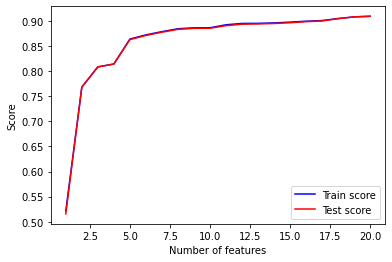

In [287]:
num_features = list(range(1,21))
fig = sns.lineplot(x = num_features, y = mean_train, color = 'b', label = 'Train score')
fig = sns.lineplot(x = num_features, y = mean_test, color = 'r', label = 'Test score')
fig.set_xlabel('Number of features')
fig.set_ylabel('Score')
plt.legend()
plt.savefig('score_vs_num_features.png', dpi = 300)